# ferminet - Fermionic Neural Network
I wrote this library for my internship at TUM. It reproduces the results of [Pfau et al. (2020)](https://link.aps.org/doi/10.1103/PhysRevResearch.2.033429 "Ab initio solution of the many-electron Schrödinger equation with deep neural networks"), which trains so-called Fermionic Neural Network to find the ground state wave functions of an atom or a molecule using neural network quantum states, see [Carleo and Troyer (2017)](https://dx.doi.org/10.1126/science.aag2302 "Solving the quantum many-body problem with artificial neural networks").

## Usage
Here is an example for a Lithium atom.

In [1]:

import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt


from ferminet_tum.atom import Atom
from ferminet_tum.network import FermiNet
from ferminet_tum.hamiltonian import Hamiltonian
from ferminet_tum.sampler import Sampler
from ferminet_tum.driver import NNQS

/opt/homebrew/Caskroom/miniforge/base/envs/jax-env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
li_atom = [Atom(id="Li", pos=jnp.array([0.0, 0.0, 0.0]))]
n_electrons = [2, 1]  # number of up- and down-spin electrons

n_1 = [32, 32, 32]  # numbers of hidden units for the one-electron stream
n_2 = [16, 16, 16]  # numbers of hidden units for the two-electron stream
n_k = 16  # number of many-electron determinants
L = len(n_1)  # number of layers

# initialize the FermiNet
fn = FermiNet(
    li_atom,
    n_electrons,
    L,
    n_k,
    n_1,
    n_2,
)
params = fn.init_params()  # initialize the parameters

In [3]:
# initialize the Hamiltonian
hamiltonian = Hamiltonian(fn)

In [4]:
n_step = 10  # number of steps in each sampling
step_std_per_dim = (
    0.02  # standard deviation of the Gaussian noise in each step for each dimension
)

# initalize the sampler
sampler = Sampler(fn, n_step, step_std_per_dim)

In [5]:
n_samples = 4096 # number of samples

# initialize the driver
nnqs = NNQS(sampler, hamiltonian, fn, n_samples)

In [6]:
n_iters = 20  # number of iterations

# training the network
params, energies = nnqs.train(n_iters, params, optax.adam(learning_rate=1e-3))

  0%|          | 0/20 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/jax-env/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [7]:
expected_energy = -7.47798 # in Hartree

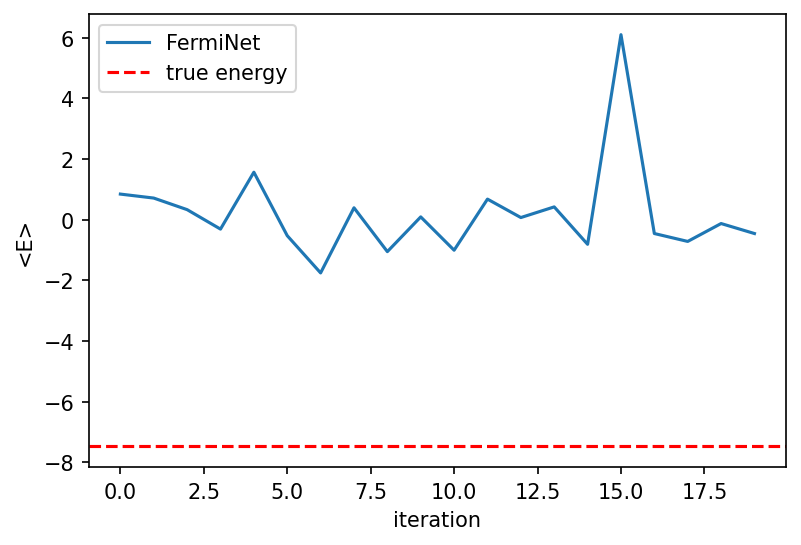

In [8]:
fig, ax = plt.subplots(dpi=150)

ax.plot(energies, label="FermiNet")
ax.set_xlabel("iteration")
ax.set_ylabel("<E>")
ax.axhline(expected_energy,color='r', linestyle='--', label="true energy")
ax.legend()